<a href="https://colab.research.google.com/github/Maria-Ul/Inverse-Scattering-Problem/blob/master/Test_on_experimental_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# загрузка данных

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import math
from sklearn.metrics import mean_absolute_error,  mean_absolute_percentage_error

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

    plt.figure(figsize=(20,20))
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Предсказание нейроести' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=1,  linewidth=0,label = 'DiRect оптимизация')

    plt.ylabel('Относительный показатель преломления m')
    plt.xlabel('Дифракционный параметр x')
    plt.legend()

    #plt.ylim(bottom=0.9)
    plt.show()



In [ ]:
class Ind_PyMieScatt(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data = pd.read_csv(csv_file, header = None).to_numpy()

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        indicatrice = np.array(sample,  dtype=np.float32)

        #Преобразование M функцией
        if self.transform is not None:
            indicatrice_new = self.transform(theta_array = torch.linspace(10, 65, 256), data_arr = indicatrice, noise = False)

        return  np.array(indicatrice_new,  dtype=np.float32)



In [ ]:
class Latex_Dataset_256_length(Dataset):

    def __init__(self, csv_file, all_filenames, root_dir, transform=None):

        self.data = pd.read_csv(csv_file,  delimiter = '\t', header = None).to_numpy()

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        angles = np.array(sample[256:],  dtype=np.float32)
        indicatrice = np.array(sample[:256],  dtype=np.float32)

        indicatrice = np.interp(torch.linspace(10, 65, 256),angles, indicatrice)

        #Преобразование M функцией
        if self.transform is not None:
            indicatrice = self.transform(theta_array = torch.linspace(10, 65, 256), data_arr = indicatrice, noise = False)


        return  np.array(indicatrice,  dtype=np.float32)



In [ ]:
class Eryth_Milk_Dataset_512_length(Dataset):

    def __init__(self, csv_file, all_filenames, root_dir, transform=None):

        self.data = pd.read_csv(csv_file,  delimiter = '\t', header = None).to_numpy()

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        angles = np.array(sample[513:-2],  dtype=np.float32)
        indicatrice = np.array(sample[1:513],  dtype=np.float32)

        indicatrice_interpol = np.interp(torch.linspace(10, 65, 256),angles, indicatrice)
#преобразование М функцией
        if self.transform is not None:
            indicatrice_new = self.transform(theta_array = torch.linspace(10, 65,256), data_arr = indicatrice_interpol, noise = False)

        return  np.array(indicatrice_new,  dtype=np.float32)



In [ ]:
def Mal_func(theta_array , data_arr, noise = False, snr = 3):
  vector_length = len(theta_array)
  w_array = np.zeros(vector_length)
  data_arr_new = np.zeros(np.array(data_arr).shape)
  for i in range(vector_length):
      theta = theta_array[i]
      w = 1/theta*math.exp(-2*(math.log(theta/54, math.e))**2)
      w_array[i] = w
      data_arr_new[i] = data_arr[i]*w_array[i]

  if noise == True:
    min_val = min(data_arr_new)
    for i in range(len(data_arr_new)):
      data_arr_new[i] = data_arr_new[i]+(2*np.random.random_sample() - 1)*min_val/snr
  return data_arr_new

In [ ]:
def metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=2*d_sd_i and abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=2*d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100
def metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=d_sd_i and abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100



# проверка интерполяцией


In [ ]:
# test =pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt', header = None, delimiter = '\t').to_numpy()
test =pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/wp_latex.txt', header = None, delimiter = '\t').to_numpy()

sample = test[300]

ind = sample[0:256]
angles = sample[256:]

In [ ]:
ind

array([ 0.284316,  0.252022,  0.225514,  0.209269,  0.198621,  0.199627,
        0.215664,  0.25126 ,  0.322412,  0.408307,  0.526936,  0.708517,
        0.937522,  1.217769,  1.553461,  1.960732,  2.423811,  2.948682,
        3.479946,  4.032433,  4.623342,  5.284659,  6.12288 ,  6.917737,
        7.576169,  8.253321,  8.97665 ,  9.605068, 10.135349, 10.593354,
       11.021549, 11.586102, 11.810165, 11.771782, 11.695132, 11.50862 ,
       11.218388, 10.71523 , 10.149579,  9.537254,  9.092792,  8.704883,
        8.12949 ,  7.536666,  6.96809 ,  6.535553,  6.212116,  6.122015,
        6.400717,  6.801992,  7.354238,  8.013897,  8.792256,  9.725472,
       10.768236, 11.786984, 12.840936, 14.022311, 15.178288, 16.288572,
       17.495937, 18.607471, 19.5207  , 20.281247, 20.983458, 21.449336,
       21.487754, 21.486922, 21.135833, 20.62721 , 19.978589, 19.190944,
       18.245012, 17.177972, 16.016622, 14.822289, 13.610653, 12.370588,
       11.241518, 10.295344,  9.62308 ,  9.124035, 

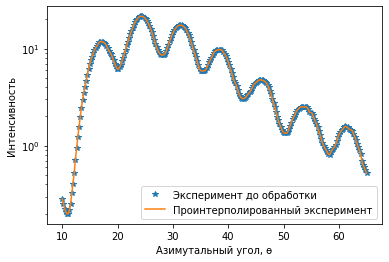

In [ ]:
plt.plot(angles, ind, marker ='*', linewidth = 0, label = 'Эксперимент до обработки')
ind_interp = np.interp(np.linspace(10, 65, 256),angles, ind)
plt.plot(torch.linspace(10, 65, 256), ind_interp, label ='Проинтерполированный эксперимент')
plt.ylabel('Интенсивность')
plt.xlabel('Азимутальный угол, ɵ')
plt.legend()
plt.yscale('log')



In [ ]:
ind_interp

проверка преобразования М функцией


In [ ]:
# res_mie = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_fit_res_2.txt',header = None, delimiter = '\t' )

In [ ]:
res_mie = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/vp_latex_fit_res_by_vp.txt',header = None, delimiter = '\t' )

In [ ]:
res_mie

,0,1,2,3,4
0,2,3.94637,1.58179,0.020932,0.005147
1,3,3.97881,1.58243,0.016165,0.004937
2,4,3.98986,1.57994,0.014779,0.004324
3,14,3.99793,1.58263,0.015890,0.004976
4,16,3.94889,1.58035,0.020308,0.004993
...,...,...,...,...,...
318,1248,3.96681,1.58183,0.017693,0.004814
319,1249,3.98477,1.58035,0.015818,0.004466
320,1255,3.98055,1.58321,0.015843,0.004942
321,1259,3.98888,1.58287,0.015465,0.004968


In [ ]:
d = res_mie[1][300]

In [ ]:
d

3.97647

In [ ]:
n = res_mie[2][300]

In [ ]:
n

1.58081

In [ ]:
# !pip install PyMieScatt
import PyMieScatt as ps


_,_,_, ind_ps = ps.ScatteringFunction(m = n,
                                          wavelength = 660,#в нанометрах
                                          diameter = d*1000, #в нанометрах
                                          nMedium = 1.333,# пп среды
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')


In [ ]:
# arr = pd.DataFrame(columns=['angles_exp', 'ind_exp', 'ang_10_65', 'ind_mie'] )


In [ ]:
# arr.iloc[:,0] = angles
# arr.iloc[:,1] = ind
# arr.iloc[0:256,2] = np.linspace(10, 65, 256)
# arr.iloc[0:256,3] = ind_ps



In [ ]:
# arr

In [ ]:
mal_ind_ps = Mal_func(torch.linspace(10, 65, 256), ind_ps, noise = False)
mal_ind_interp = Mal_func(torch.linspace(10, 65, 256), ind_interp, noise = False)


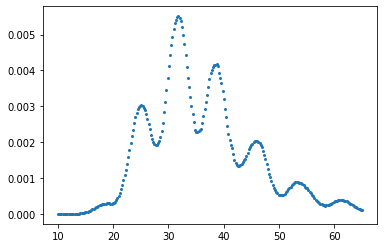

In [ ]:
plt.plot(torch.linspace(10, 65, 256), ind_interp, marker = 'o', markersize = 2, linewidth = 0, label ='Эксперимент')


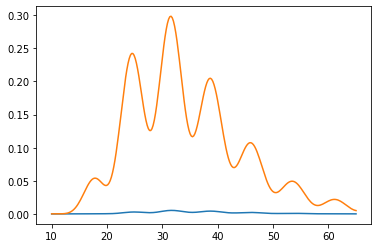

In [ ]:
plt.plot(torch.linspace(10, 65, 256), mal_ind_ps, label ='Теория Ми')
plt.plot(torch.linspace(10, 65, 256), ind_ps, label ='Теория Ми')


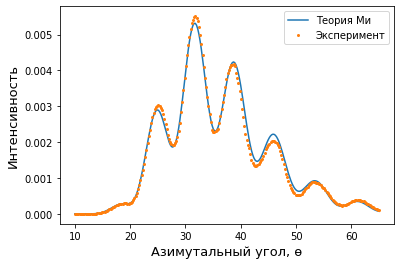

In [ ]:
plt.plot(torch.linspace(10, 65, 256), mal_ind_ps, label ='Теория Ми')
plt.plot(torch.linspace(10, 65, 256), ind_interp, marker = 'o', markersize = 2, linewidth = 0, label ='Эксперимент')
plt.xlabel('Азимутальный угол, ɵ', fontsize=13)
plt.ylabel("Интенсивность", fontsize=13)
plt.legend()



In [ ]:
# test_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt', all_filenames = 0,
#                                            root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
#                          transform = Mal_func)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

латексы мальцева

In [ ]:
test_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/wp_latex.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = None)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

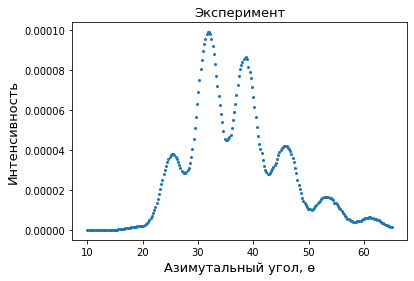

In [ ]:
# plt.plot(torch.linspace(10, 65, 256), mal_ind_ps, label ='Теория Ми')
# plt.plot(np.linspace(10, 65, 256), test_data[300], label = 'dataloader')
plt.plot(np.linspace(10, 65, 256), mal_ind_interp, marker = 'o', markersize = 2, linewidth = 0)##, label ='Эксперимент')
plt.xlabel('Азимутальный угол, ɵ', fontsize=13)
plt.ylabel("Интенсивность", fontsize=13)
plt.title('Эксперимент', fontsize=13)
#plt.legend()
plt.savefig('эксперимент.svg')
#plt.yscale('log')

# Проверка работы сети


In [ ]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')
print(device)

cpu


In [ ]:
class FC_Net_2(nn.Module):
    def __init__(self):
        super(FC_Net_2, self).__init__()

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 400)
        self.fc3 = nn.Linear(400, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        return x

#304194 params


In [ ]:
class ConvNet_new(nn.Module):
    def __init__(self):
        super(ConvNet_new, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=21, kernel_size=7, padding=3)#lout = 256
        #Lin = Lout => p = (k_s-1)/2
        #Lout = Lin
        self.conv2 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv3 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv4 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256

        #Lout = Lin/2 and channels_out*2 (due to 34-layers plains and 34-layers ResNet)  => p = (k-1)/2 - Lin/4
        self.conv5 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=3, stride = 2, padding=1)# lout =128
        #Lout = Lin
        self.conv6 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128
        self.conv7 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128

        #Lout = Lin/2 and channels_out*2
        self.conv8 = nn.Conv1d(in_channels=42, out_channels=84, kernel_size=3, stride = 2, padding=1)# lout = 64
        #Lout = Lin
        self.conv9 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64
        self.conv10 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64

        #reducing out_ch value. Lout = Lin
        self.conv11= nn.Conv1d(in_channels=84, out_channels=42, kernel_size=1, padding=0)#lout = 64
        self.conv12= nn.Conv1d(in_channels=42, out_channels=21, kernel_size=1, padding=0)#lout =64
        self.conv13= nn.Conv1d(in_channels=21, out_channels=1, kernel_size=1, padding=0)#lout = 64

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return x

#75353 params

In [ ]:
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 300)
        self.fc3 = nn.Linear(300, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        return x

#261230 params

In [ ]:
class Modified_seven_ConvNet_Tanh(nn.Module):
    def __init__(self):
        super(Modified_seven_ConvNet_Tanh, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=2)
        self.bn5 = nn.BatchNorm1d(num_features=16)
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=13, padding=2)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=17, padding=2)
        self.bn7 = nn.BatchNorm1d(num_features=16)
        self.conv7 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=23, padding=2)
        self.bn8 = nn.BatchNorm1d(num_features=8)
        self.fc1 = nn.Linear(1696, 180)#
        self.fc2 = nn.Linear(180, 2)


    def forward(self, x):
        x = self.bn1(x)
        x = torch.tanh(self.conv1(x))
        x = self.bn2(x)
        x = torch.tanh(self.conv2(x))
        x = self.bn3(x)
        x = torch.tanh(self.conv3(x))
        x = self.bn4(x)
        x = torch.tanh(self.conv4(x))
        x = self.bn5(x)
        x = torch.tanh(self.conv5(x))
        x = self.bn6(x)
        x = torch.tanh(self.conv6(x))
        x = self.bn7(x)
        x = torch.tanh(self.conv7(x))
        x = self.bn8(x)

        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [ ]:
class FC_Net_2(nn.Module):
    def __init__(self):
        super(FC_Net_2, self).__init__()

        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        return x

#304194 params


In [ ]:
class Modified_seven_ConvNet(nn.Module):
    def __init__(self):
        super(Modified_seven_ConvNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=2)
        self.bn5 = nn.BatchNorm1d(num_features=16)
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=13, padding=2)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=17, padding=2)
        self.bn7 = nn.BatchNorm1d(num_features=16)
        self.conv7 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=23, padding=2)
        self.bn8 = nn.BatchNorm1d(num_features=8)
        self.fc1 = nn.Linear(1696, 180)#
        self.fc2 = nn.Linear(180, 2)


    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.conv1(x))
        x = self.bn2(x)
        x = F.relu(self.conv2(x))
        x = self.bn3(x)
        x = F.relu(self.conv3(x))
        x = self.bn4(x)
        x = F.relu(self.conv4(x))
        x = self.bn5(x)
        x = F.relu(self.conv5(x))
        x = self.bn6(x)
        x = F.relu(self.conv6(x))
        x = self.bn7(x)
        x = F.relu(self.conv7(x))
        x = self.bn8(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=21, kernel_size=7, padding=3)
        #Lin = Lout => p = (k_s-1)/2
        #Lout = Lin
        self.conv2 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)

        #Lout = Lin/2 and channels_out*2 (due to 34-layers plains and 34-layers ResNet)  => p = (k-1)/2 - Lin/4
        self.conv5 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=3, stride = 2, padding=0)
        #Lout = Lin
        self.conv6 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)
        self.conv7 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)

        #Lout = Lin/2 and channels_out*2
        self.conv8 = nn.Conv1d(in_channels=42, out_channels=84, kernel_size=3, stride = 2, padding=0)
        #Lout = Lin
        self.conv9 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)
        self.conv10 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)

        #reducing out_ch value. Lout = Lin
        self.conv11= nn.Conv1d(in_channels=84, out_channels=42, kernel_size=1, padding=0)
        self.conv12= nn.Conv1d(in_channels=42, out_channels=21, kernel_size=1, padding=0)
        self.conv13= nn.Conv1d(in_channels=21, out_channels=1, kernel_size=1, padding=0)

        self.fc1 = nn.Linear(63, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return x

#75353 params

In [ ]:
class StagedClusterNet(nn.Module):
    def __init__(self):
        super(StagedClusterNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.conv11 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=2)
        self.conv12 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=4)
        self.conv13 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=8)
        self.conv14 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=2)
        self.bn5 = nn.BatchNorm1d(num_features=16)
        self.conv15 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=13, padding=2)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.conv16 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=17, padding=2)
        self.bn7 = nn.BatchNorm1d(num_features=16)
        self.conv17 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=23, padding=2)
        self.bn8 = nn.BatchNorm1d(num_features=8)
        self.fc11 = nn.Linear(1696, 180)#
        self.fc12 = nn.Linear(180, 2) #(m,x)


        self.conv21 = nn.Conv1d(in_channels=1, out_channels=21, kernel_size=7, padding=3)
        #Lin = Lout => p = (k_s-1)/2
        #Lout = Lin
        self.conv22 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)
        self.conv23 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)
        self.conv24 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)

        #Lout = Lin/2 and channels_out*2 (due to 34-layers plains and 34-layers ResNet)  => p = (k-1)/2 - Lin/4
        self.conv25 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=3, stride = 2, padding=0)
        #Lout = Lin
        self.conv26 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)
        self.conv27 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)

        #Lout = Lin/2 and channels_out*2
        self.conv28 = nn.Conv1d(in_channels=42, out_channels=84, kernel_size=3, stride = 2, padding=0)
        #Lout = Lin
        self.conv29 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)
        self.conv210 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)

        #reducing out_ch value. Lout = Lin
        self.conv211= nn.Conv1d(in_channels=84, out_channels=42, kernel_size=1, padding=0)
        self.conv212= nn.Conv1d(in_channels=42, out_channels=21, kernel_size=1, padding=0)
        self.conv213= nn.Conv1d(in_channels=21, out_channels=1, kernel_size=1, padding=0)

        self.fc21 = nn.Linear(64, 2) #63+1



    def forward(self, inp):
        x = self.bn1(inp)
        x = F.relu(self.conv11(x))
        x = self.bn2(x)
        x = F.relu(self.conv12(x))
        x = self.bn3(x)
        x = F.relu(self.conv13(x))
        x = self.bn4(x)
        x = F.relu(self.conv14(x))
        x = self.bn5(x)
        x = F.relu(self.conv15(x))
        x = self.bn6(x)
        x = F.relu(self.conv16(x))
        x = self.bn7(x)
        x = F.relu(self.conv17(x))
        x = self.bn8(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x)) #(m,x)

        x1 = torch.reshape(x[:,0], (len(x[:,0]),1)) # (m)

        x = F.relu(self.conv21(inp))
        x = F.relu(self.conv22(x))
        x = F.relu(self.conv23(x))
        x = F.relu(self.conv24(x))
        x = F.relu(self.conv25(x))
        x = F.relu(self.conv26(x))
        x = F.relu(self.conv27(x))
        x = F.relu(self.conv28(x))
        x = F.relu(self.conv29(x))
        x = F.relu(self.conv210(x))
        x = F.relu(self.conv211(x))
        x = F.relu(self.conv212(x))
        x = F.relu(self.conv213(x))


        x = torch.flatten(x, 1)
        x2 = torch.cat([x,x1], dim = 1)


        x = F.relu(self.fc21(x2))

        return x

#401417

# сравнение с методом нелинейной регрессии

Load test dataset

латексы мальцева

In [ ]:
test_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/wp_latex.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = None)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

latex

In [ ]:
test_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = Mal_func)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

milk

In [ ]:
test_data = Eryth_Milk_Dataset_512_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = Mal_func)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

эритроциты

In [ ]:
test_data = Eryth_Milk_Dataset_512_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/сфериз. эритр/eryth_late_#1_i22434_spherized_v2', all_filenames = 0,
                                           root_dir=' ',
                         transform = Mal_func)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

Тестирование и сохранение результатов в файл

In [ ]:
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.pt'


In [ ]:
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/ConvNet_best_1sd_metric_2.pt'

In [ ]:
model = ConvNet_new().to(device)


optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))#)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)#

epochs = checkpoint['epoch']
loss = checkpoint['loss']
loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']
#val_history = checkpoint['val_history']

epochs = np.linspace(0,len(loss_history) , len(loss_history))

model.eval()
with torch.no_grad():
  for i_step, (x) in enumerate(test_loader):
    x = x.unsqueeze(1)
    prediction = model(x.to(device))
    prediction = prediction.squeeze(1)
    prediction_arr = (prediction.cpu().detach().numpy())


prediction_arr = np.squeeze(prediction_arr)
load_path = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/ConvNet_best_1sd_metric_2.txt'
np.savetxt(load_path, prediction_arr, delimiter=",")



In [ ]:
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.pt'

model = Modified_seven_ConvNet().to(device)


optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))#)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)#

epochs = checkpoint['epoch']
loss = checkpoint['loss']
loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']
#val_history = checkpoint['val_history']

epochs = np.linspace(0,len(loss_history) , len(loss_history))

model.eval()
with torch.no_grad():
  for i_step, (x) in enumerate(test_loader):
    x = x.unsqueeze(1)
    prediction = model(x.to(device))
    prediction = prediction.squeeze(1)
    prediction_arr = (prediction.cpu().detach().numpy())


prediction_arr = np.squeeze(prediction_arr)
load_path = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'
np.savetxt(load_path, prediction_arr, delimiter=",")



In [ ]:
load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/ConvNet_best_1sd_metric_2.txt'

load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'


Тест


eryrthocyte

In [ ]:
class Mie_res_Eryth:
  def __init__(self):
    self.dataframe = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/сфериз. эритр/eryth_late_#1_i22434_Mie_results',header = 0 ,delimiter = '\t')
    self.d = self.dataframe['d n'].to_numpy()
    self.n = self.dataframe['ri n'].to_numpy()
    self.d_sd = self.dataframe['d sd'].to_numpy()
    self.n_sd = self.dataframe['ri sd'].to_numpy()

In [ ]:
class NN_pred_Eryth:
  def __init__(self, PATH):
    self.dataframe = pd.read_csv(PATH, header= None)
    self.d = self.dataframe[1]/(1.333*math.pi/0.66) #mkm
    self.n = self.dataframe[0]*1.333




In [ ]:
# d_n = Mie_res['d n'].to_numpy() #mkm
# ri_n = Mie_res['ri n'].to_numpy()
# d_sd = Mie_res['d sd'].to_numpy()# mkm
# ri_sd = Mie_res['ri sd'].to_numpy()

load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/ConvNet_best_1sd_metric_2.txt'
load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (эритроциты)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'

d_n = Mie_res_Eryth().d
ri_n = Mie_res_Eryth().n
d_sd = Mie_res_Eryth().d_sd
ri_sd = Mie_res_Eryth().n_sd
d_pred = NN_pred_Eryth(PATH = load_path_d).d
ri_pred = NN_pred_Eryth(PATH = load_path_n).n

new latex


In [ ]:
Mie_res= pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_fit_res_2.txt',header = None ,delimiter = '\t')

NameError: ignored

In [ ]:
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()

In [ ]:
# load_path = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart9_long'


In [ ]:
load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/предсказания сети/ConvNet_best_1sd_metric_2.txt'
load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/предсказания сети/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'


In [ ]:
NN_res = pd.read_csv(load_path_n, header= None)
ri_pred = NN_res[0]*1.333
NN_res = pd.read_csv(load_path_n, header= None)
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm

In [ ]:
# ri_pred = NN_res[0]*1.333
# d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm

латексы мальцева

In [ ]:
malcev_res = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/vp_latex_fit_res_by_vp.txt',header = None ,delimiter = '\t')

In [ ]:
Mie_res = malcev_res
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,3].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,4].to_numpy()

In [ ]:
load_path = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/латексы от мальецва (12.22)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart9_long'


In [ ]:
NN_res = pd.read_csv(load_path, header= None)

In [ ]:
ri_pred = NN_res[0]*1.333
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm

milk

In [ ]:
Mie_res= pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm_Mie_sphere',header = 0 ,delimiter = '\t')

In [ ]:
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()

In [ ]:
load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (молоко)/ConvNet_best_1sd_metric_2.txt'
load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (молоко)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'

In [ ]:
NN_res = pd.read_csv(load_path_n, header= None)
ri_pred = NN_res[0]*1.333
NN_res = pd.read_csv(load_path_d , header= None)
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm


# Test on experimental data

In [ ]:
Mie_res

,ind_number,size,RI,size (math exp),RI (math exp),size (st dev),RI (st dev)
0,1,1.678746,1.452492,1.678411,1.452462,0.019183,0.002941
1,2,3.424033,1.446592,3.422217,1.446633,0.027501,0.002840
2,3,1.118575,1.455291,1.116627,1.455672,0.040023,0.007057
3,4,2.251067,1.452724,2.250931,1.452695,0.016781,0.002318
4,5,5.710906,1.442421,5.705953,1.442595,0.082980,0.004988
...,...,...,...,...,...,...,...
9786,10078,1.029073,1.408916,1.027401,1.409191,0.042431,0.005110
9787,10079,0.500021,1.350002,2.322570,1.432401,1.757165,0.078608
9788,10080,6.451773,1.350001,4.593833,1.422746,1.928600,0.077998
9789,10081,2.883211,1.366453,2.290516,1.392434,1.141844,0.051780


In [ ]:
NN_res

In [ ]:
#'𝜎'\u03C3

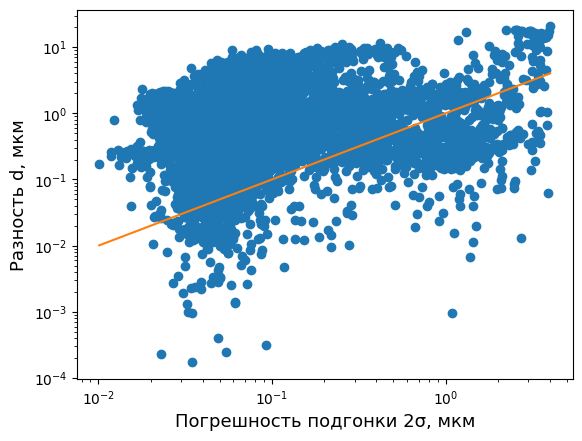

In [ ]:
plt.plot(2*d_sd, abs(d_n - d_pred), linewidth = 0 , marker ='o')
plt.plot(np.linspace(2*min(d_sd),2*max(d_sd),2), np.linspace(2*min(d_sd),2*max(d_sd),2))
plt.xlabel('Погрешность подгонки 2\u03C3, мкм', fontsize = 13)
plt.ylabel('Разность d, мкм', fontsize = 13)
plt.yscale('log')
plt.xscale('log')

plt.savefig("Разность d milk.svg")

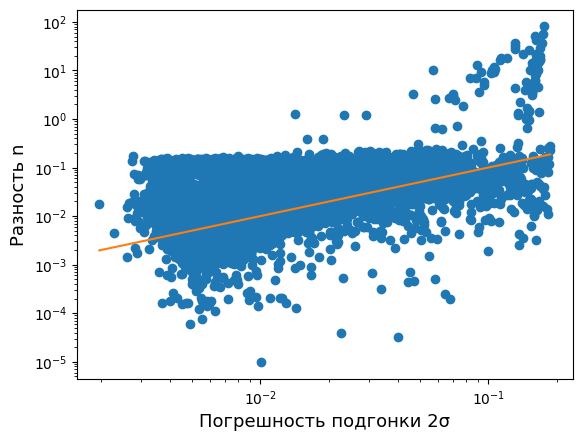

In [ ]:
plt.plot(2*ri_sd, abs(ri_n - ri_pred), linewidth = 0 , marker ='o')
plt.plot(np.linspace(2*min(ri_sd),2*max(ri_sd),2), np.linspace(2*min(ri_sd),2*max(ri_sd),2))
#plt.plot(np.linspace(min(2*ri_sd),max(2*ri_sd),2), np.linspace(min(2*ri_sd),max(2*ri_sd),2))

plt.xlabel('Погрешность подгонки 2\u03C3', fontsize = 13)
plt.ylabel('Разность n', fontsize = 13)
plt.yscale('log')
plt.xscale('log')

plt.savefig("Разность n milk.svg")

In [ ]:
def metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=2*d_sd_i and abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=2*d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100

a = metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')




cross_area = 4.575630681237872%, d_area = 8.415892145848227%, n_area  = 15.218057399652743%


In [ ]:
def metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    cross_area = 0
    d_counter = 0
    ri_counter = 0
    length = len(d_pred)
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=d_sd_i and abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        cross_area+=1
      if abs(d_n_i-d_pred_i)<=d_sd_i:
        d_counter+=1
      if abs(ri_n_i-ri_pred_i)<=ri_sd_i:
        ri_counter+=1

    return cross_area/length*100, d_counter/length*100, ri_counter/length*100

a = metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')




cross_area = 1.429884587886835%, d_area = 4.8922479828413845%, n_area  = 6.659176795015831%


In [ ]:
def vizualize_area(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd):
    length = len(d_pred)
    plt.figure(figsize=(10,10))
    arr_d_pred = []
    arr_ri_pred = []
    for i in range(length):
      d_n_i = d_n[i]
      d_pred_i = d_pred[i]
      d_sd_i = d_sd[i]
      ri_n_i = ri_n[i]
      ri_pred_i = ri_pred[i]
      ri_sd_i = ri_sd[i]

      if abs(d_n_i-d_pred_i)<=2*d_sd_i and abs(ri_n_i-ri_pred_i)<=2*ri_sd_i:
          # print('smth')
          arr_d_pred.append(d_pred_i)
          arr_ri_pred.append(ri_pred_i)

    plt.plot(d_pred, ri_pred, linewidth = 0, marker = 'o', markersize = 3, color = 'black', label = 'Предсказание нейроести несовпало' )
    #plt.errorbar(d_n, ri_n, xerr=d_sd, yerr=ri_sd,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=1,  linewidth=0,label = 'DiRect оптимизация')
    plt.plot(arr_d_pred, arr_ri_pred, linewidth = 0, marker = 'o', markersize = 3, color = 'r', label = 'Предсказание нейроести совпало' )

    plt.ylabel('Показатель преломления n ')
    plt.xlabel('Диаметр d')
    plt.legend()


    plt.show()
   # print(arr_d_pred, arr_ri_pred)

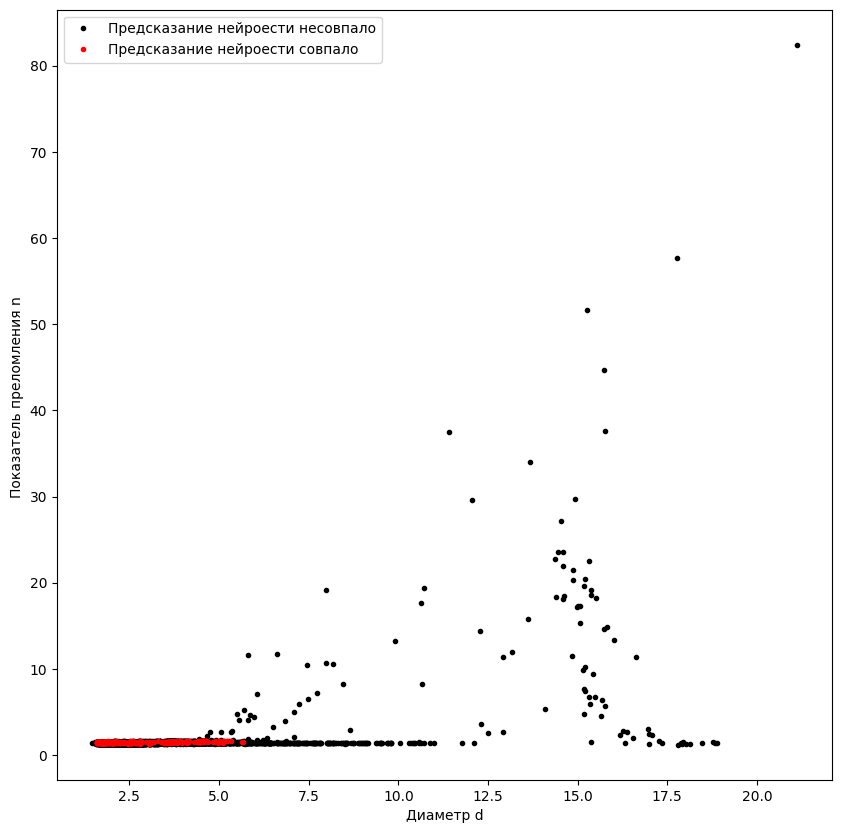

In [ ]:
vizualize_area(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)

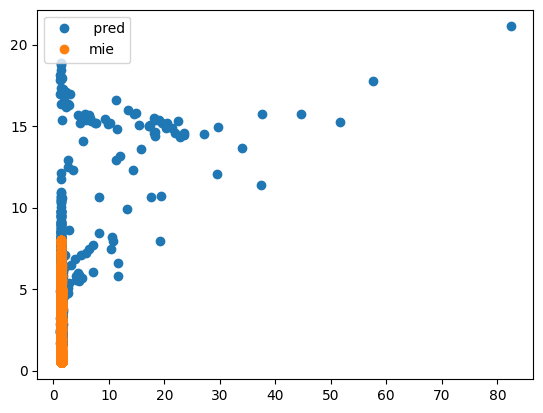

In [ ]:

plt.plot(ri_pred, d_pred, label = ' pred', marker = 'o' , linewidth = 0)
plt.legend()
plt.plot(ri_n, d_n, label = 'mie', marker = 'o' , linewidth = 0)
plt.legend()


In [ ]:
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm
ri_pred = NN_res[0]*1.333

In [ ]:
d_pred = d_pred.tolist()
d_n = d_n.tolist()
d_sd = d_sd.tolist()

In [ ]:
ri_pred = ri_pred.tolist()
ri_n = ri_n.tolist()
ri_sd = ri_sd.tolist()

In [ ]:
# csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt'
# angles = np.array(data[:,256:],  dtype=np.float32)
# indicatrice = np.array(data[:,:256],  dtype=np.float32)



milk


In [ ]:
csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm.txt'
data = pd.read_csv(csv_file,  delimiter = '\t').to_numpy()
angles = np.array(data[:, 513:-2],  dtype=np.float32)
indicatrice = np.array(data[:,1:513],  dtype=np.float32)

erythrocytes

In [ ]:
csv_file =
data = pd.read_csv(csv_file,  delimiter = '\t').to_numpy()
angles = np.array(data[:, 513:-2],  dtype=np.float32)
indicatrice = np.array(data[:,1:513],  dtype=np.float32)

In [ ]:
indicatrice[0]

array([1.6787456, 1.452492 , 1.6784106, 1.4524617, 0.0191833, 0.002941 ],
      dtype=float32)

In [ ]:
# k = 0
# while k <10:
#   k+=1
#   maximum = max(ri_pred)
#   index = ri_pred.index(maximum)
#   d_pred.remove(d_pred[index])
#   d_n.remove(d_n[index])
#   ri_pred.remove(ri_pred[index])
#   ri_n.remove(ri_n[index])
#   ri_sd.remove(ri_sd[index])
#   d_sd.remove(d_sd[index])
#   indicatrice.remove(indicatrice[index])
# k = 0
# while k <10:
#   k+=1
#   maximum = max(d_pred)
#   index = d_pred.index(maximum)
#   ri_pred.remove(ri_pred[index])
#   d_pred.remove(d_pred[index])
#   ri_n.remove(ri_n[index])
#   d_n.remove(d_n[index])
#   ri_sd.remove(ri_sd[index])
#   d_sd.remove(d_sd[index])
#   indicatrice.remove(indicatrice[index])



In [ ]:
indicatrice_new = np.zeros((len(indicatrice),256))
for i in range(len(indicatrice)):
  indicatrice_new[i] = np.interp(torch.linspace(10, 65, 256), angles[i], indicatrice[i])
  indicatrice_new[i] = Mal_func(theta_array = torch.linspace(10, 65,256), data_arr = indicatrice_new[i], noise = False)



In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

   # plt.figure(figsize=(10,8))
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Предсказание нейросети' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=0.3,  linewidth=0,label = 'DiRect оптимизация')

    plt.ylabel('Относительный\n показатель преломления m', fontsize = 15)
    plt.xlabel('Дифракционный параметр x' , fontsize = 15)
    plt.legend()
    plt.savefig("Предсказание нейросети.svg")
    # plt.ylim(0.8,1.35)
    # plt.xlim(-10,80)
    plt.show()

In [ ]:
ri_pred = np.array(ri_pred)
d_pred = np.array(d_pred)
ri_n = np.array(ri_n)
d_n = np.array(d_n)
ri_sd = np.array(ri_sd)
d_sd = np.array(d_sd)
# indicatrice_new = np.array(indicatrice_new)


In [ ]:
ri_pred_new = []
d_pred_new= []
ri_n_new = []
d_n_new = []
d_sd_new = []
ri_sd_new = []

In [ ]:
np.shape((d_n))

(9791,)

In [ ]:
for i in range(len(d_pred)):
  if d_pred[i] <= 4.07:
    d_n_new.append(d_n[i])
    ri_n_new.append(ri_n[i])
    d_sd_new.append(d_sd[i])
    ri_sd_new.append(ri_sd[i])
    d_pred_new.append(d_pred[i])
    ri_pred_new.append(ri_pred[i])

In [ ]:
# milk
# ri_pred_new = []
# d_pred_new= []
# ri_n_new = []
# d_n_new = []
# d_sd_new = []
# ri_sd_new = []
# for i in range(len(d_pred)):
#   if d_n[i] >= 1.73:
#     d_n_new.append(d_n[i])
#     ri_n_new.append(ri_n[i])
#     d_sd_new.append(d_sd[i])
#     ri_sd_new.append(ri_sd[i])
#     d_pred_new.append(d_pred[i])
#     ri_pred_new.append(ri_pred[i])

In [ ]:
len(d_pred_new)

6020

In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

    plt.figure(figsize=(8,8))
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Neural network prediction' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=0.3,  linewidth=0,label = 'DiRect optimization')

    plt.ylabel('Refractive index n', fontsize = 15)
    plt.xlabel('Diameter d, mkm' , fontsize = 15)
    plt.legend()
    plt.ylim(1.25,1.85)
    plt.xlim(0,11.5)
    plt.savefig("Предсказание нейросети milk uni.svg")

    plt.show()

In [ ]:
# graphs(m_pred = ri_pred, x_pred = d_pred,  m_mie = ri_n, x_mie = d_n, xerr = d_sd, merr =ri_sd )

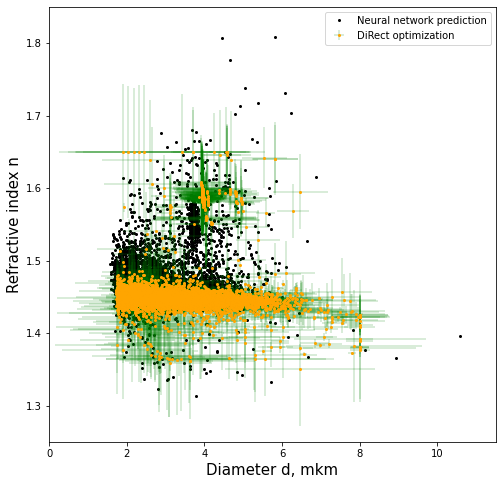

In [ ]:
graphs(m_pred = ri_pred_new, x_pred = d_pred_new,  m_mie = ri_n_new, x_mie = d_n_new, xerr = d_sd_new, merr =ri_sd_new )

Сравнение теории ми эксперимента и нейросети на индикатрисах

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


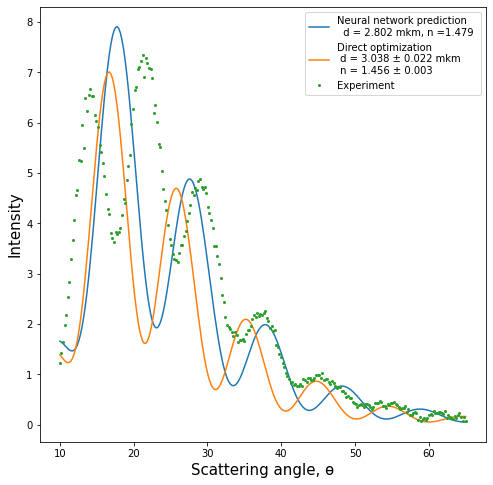

In [ ]:
pip install PyMieScatt
import PyMieScatt as ps
index = 5#10 80 5
r_i = ri_pred[index]
d = d_pred[index]*1000
_,_,_, ind_nn = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_nn, noise = False)
plt.figure(figsize=(8,8))
plt.plot(np.linspace(10,65,256),indm,  label = f'Neural network prediction\n  d = {round(d/1000,3)} mkm, n ={round(r_i,3)} ')
#plt.title('Результат для латексных шаров', fontsize=13)
plt.legend()

r_i = ri_n[index]
d = d_n[index]*1000
_,_,_, ind_mie = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_mie, noise = False)
plt.plot(np.linspace(10,65,256),indm, label = f'Direct optimization\n d = {round(d/1000,3)} ± {round(d_sd[index],3)} mkm\n n = {round(ri_n[index],3)} ± {round(ri_sd[index],3)}')

#эксперимент

plt.plot(torch.linspace(10, 65, 256), indicatrice_new[index], marker = 'o', markersize = 2,linewidth = 0, label = 'Experiment')
# test_data[index]
plt.xlabel('Scattering angle, ɵ', fontsize=15)
plt.ylabel("Intensity", fontsize=15)
plt.legend()
plt.savefig('Результат для молока_ 2.svg')


In [ ]:
g = 0
for i in range(len(NN_res)):

  r_i = ri_pred[i]
  d = d_pred[i]*1000
  _,_,_, ind_nn = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')


  r_i = ri_n[i]
  d = d_n[i]*1000
  _,_,_, ind_mie = ps.ScatteringFunction(m = r_i,
                                            wavelength = 660,
                                            diameter = d,
                                            nMedium = 1.333,
                                            minAngle = 10,
                                            maxAngle = 65,
                                            angularResolution = 55/255,
                                            space = 'theta',
                                            angleMeasure = 'degrees')


  r = 0
  for i in range(256):
    r += ((ind_nn[i] - ind_mie[i])**2)/256

  g+=r/len(NN_res)
g

KeyboardInterrupt: ignored

In [ ]:
mse_arr =[11981.002749272884, 12097.661634006527,12562.540988764631,13758.843106662813,32074.865911427787,47225.16036969636 ,116956.79399418899, 505141.3446767168, 2329560.6060939603, 3699457.2080226415
]
snr =['10', '8','5','3','1',  '0.8', '0.5','0.3', '0.1', 'Эксперимент' ]
#snr = snr[-10:]
# plt.yscale('log')
# plt.xlabel('SNR')
# plt.ylabel('MSE')

In [ ]:
# mse_arr =[11981.002749272884, 12097.661634006527,12562.540988764631,13758.843106662813,32074.865911427787,47225.16036969636 ,116956.79399418899, 505141.3446767168, 2329560.6060939603]
# snr =[10,8, 5,3, 1,0.8, 0.5,0.3, 0.1]

Text(0, 0.5, 'MSE')

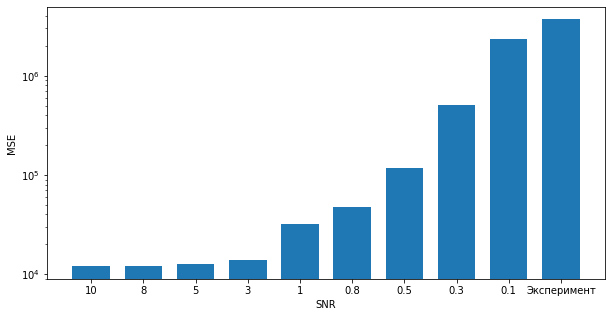

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(np.linspace(0, len(mse_arr), len(mse_arr)), mse_arr, width = 0.8,tick_label = snr)

plt.yscale('log')
ax.set_xlabel('SNR')
ax.set_ylabel('MSE')



(array([7., 0., 0., 0., 0., 0., 0., 1.]),
 array([   4716.67245174,  458266.19941142,  911815.72637111,
        1365365.2533308 , 1818914.78029049, 2272464.30725018,
        2726013.83420986, 3179563.36116955, 3633112.88812924]),
 <a list of 8 Patch objects>)

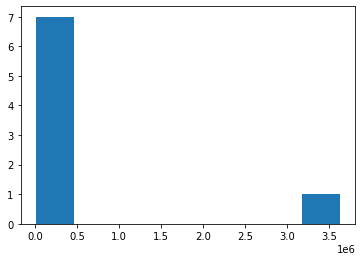

In [ ]:
plt.hist(mse_arr, bins = len(mse_arr))

# latex

In [ ]:
test_data = Latex_Dataset_256_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = Mal_func)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [ ]:
Mie_res= pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_fit_res_2.txt',header = None ,delimiter = '\t')

In [ ]:
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()

In [ ]:
load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/предсказания сети/ConvNet_best_1sd_metric_2.txt'
load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/предсказания сети/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'


In [ ]:
NN_res = pd.read_csv(load_path_d, header= None)
ri_pred = NN_res[0]*1.333
# NN_res = pd.read_csv(load_path_d, header= None)
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm

In [ ]:
a = metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'2sd cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')

a = metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'1sd cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')

2sd cross_area = 2.8125%, d_area = 59.06249999999999%, n_area  = 3.4375000000000004%
1sd cross_area = 0.625%, d_area = 34.375%, n_area  = 1.875%


In [ ]:
ri_pred = np.array(ri_pred)
d_pred = np.array(d_pred)
ri_n = np.array(ri_n)
d_n = np.array(d_n)
ri_sd = np.array(ri_sd)
d_sd = np.array(d_sd)
# indicatrice_new = np.array(indicatrice_new)

In [ ]:
np.mean(abs(d_pred-d_n)/d_n*100)

0.573945141439039

In [ ]:
np.max(abs(d_pred-d_n)/d_n*100)

9.071925819110405

In [ ]:
np.mean((ri_pred-ri_n)/ri_n*100)

2.4050490868233636

In [ ]:
np.max((ri_pred-ri_n)/ri_n*100)

5.113909014042702

In [ ]:
print('''\u03BC''')

μ


In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

    plt.figure(figsize=(8,8))
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Neural network prediction' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=0.3,  linewidth=0,label = 'DiRect optimization')

    plt.ylabel('Refractive index n', fontsize = 18)
    plt.xlabel('Diameter d, \u03BCm' , fontsize = 18)
    plt.legend()
    # plt.xlim(3.8,4.1)
    # plt.ylim(1.565,1.595)
    plt.savefig("Предсказание нейросети latex vgg.svg")

    plt.show()

In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

    plt.figure()
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Neural network prediction' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=0.3,  linewidth=0,label = 'DiRect optimization')

    plt.ylabel('Refractive index n', fontsize = 12)
    plt.xlabel('Diameter d, \u03BCm' , fontsize = 12)
    plt.legend()
    # plt.xlim(3.8,4.1)
    # plt.ylim(1.565,1.595)
    plt.savefig("Предсказание нейросети latex vgg.svg")

    plt.show()

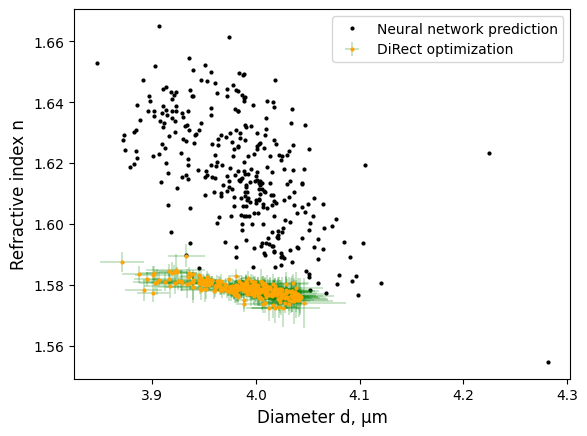

In [ ]:
graphs(m_pred = ri_pred, x_pred = d_pred,  m_mie = ri_n, x_mie = d_n, xerr = d_sd, merr =ri_sd )


In [ ]:
csv_file ='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/новые латексы/vp_latex_2.txt'
data = pd.read_csv(csv_file,  delimiter = '\t').to_numpy()
angles = np.array(data[:, 256:],  dtype=np.float32)
indicatrice = np.array(data[:,:256],  dtype=np.float32)

In [ ]:
indicatrice_new = np.zeros((len(indicatrice),256))
for i in range(len(indicatrice)):
  indicatrice_new[i] = np.interp(torch.linspace(10, 65, 256), angles[i], indicatrice[i])
  indicatrice_new[i] = Mal_func(theta_array = torch.linspace(10, 65,256), data_arr = indicatrice_new[i], noise = False)



In [ ]:
indicatrice_new_2 = np.zeros((len(indicatrice),256))
for i in range(len(indicatrice)):
  indicatrice_new_2[i] = np.interp(torch.linspace(10, 65, 256), angles[i], indicatrice[i])

In [ ]:
!pip install PyMieScatt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


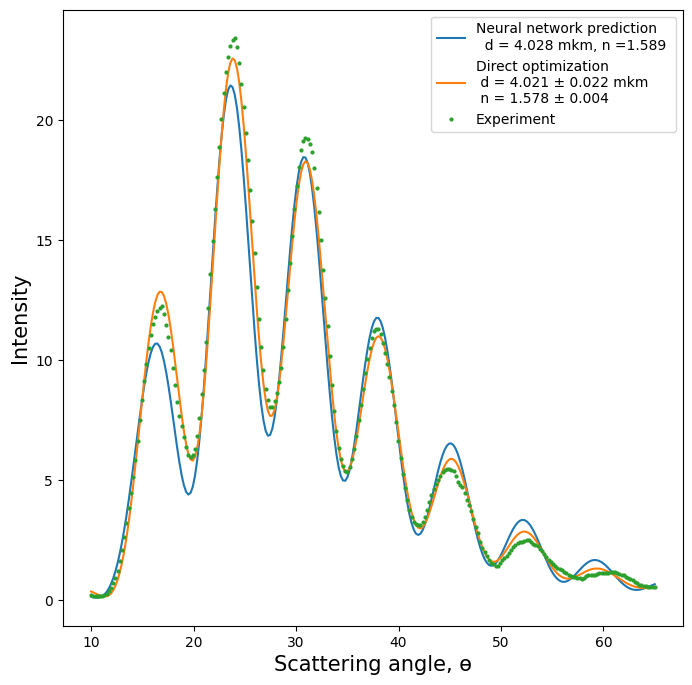

In [ ]:
import PyMieScatt as ps
index = 95#10 80 5
r_i = ri_pred[index]
d = d_pred[index]*1000
_,_,_, ind_nn = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_nn, noise = False)
plt.figure(figsize=(8,8))
plt.plot(np.linspace(10,65,256),indm,  label = f'Neural network prediction\n  d = {round(d/1000,3)} mkm, n ={round(r_i,3)} ')
#plt.title('Результат для латексных шаров', fontsize=13)
plt.legend()

r_i = ri_n[index]
d = d_n[index]*1000
_,_,_, ind_mie = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_mie, noise = False)
plt.plot(np.linspace(10,65,256),indm, label = f'Direct optimization\n d = {round(d/1000,3)} ± {round(d_sd[index],3)} mkm\n n = {round(ri_n[index],3)} ± {round(ri_sd[index],3)}')

#эксперимент

plt.plot(torch.linspace(10, 65, 256), indicatrice_new[index], marker = 'o', markersize = 2,linewidth = 0, label = 'Experiment')
# test_data[index]
plt.xlabel('Scattering angle, ɵ', fontsize=15)
plt.ylabel("Intensity", fontsize=15)
plt.legend()
plt.savefig('Результат для latex vgg.svg')


#milk


In [ ]:
test_data = Eryth_Milk_Dataset_512_length(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm.txt', all_filenames = 0,
                                           root_dir='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/',
                         transform = Mal_func)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

milk

In [ ]:
Mie_res= pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm_Mie_sphere',header = 0 ,delimiter = '\t')

In [ ]:
d_n = Mie_res.iloc[:,1].to_numpy()#mkm
ri_n = Mie_res.iloc[:,2].to_numpy()
d_sd = Mie_res.iloc[:,5].to_numpy()#mkm
ri_sd = Mie_res.iloc[:,6].to_numpy()

In [ ]:
load_path_d = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (молоко)/ConvNet_best_1sd_metric_2.txt'
load_path_n = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/предсказания сети (молоко)/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart10_long.txt'

In [ ]:
NN_res = pd.read_csv(load_path_n, header= None)
ri_pred = NN_res[0]*1.333
NN_res = pd.read_csv(load_path_d , header= None)
d_pred = NN_res[1]/(1.333*math.pi/0.66) #mkm

In [ ]:
a = metric_2sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'2sd cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')

a = metric_1sd_area_percent(d_n, d_pred, d_sd, ri_n , ri_pred, ri_sd)
print(f'1sd cross_area = {a[0]}%, d_area = {a[1]}%, n_area  = {a[2]}%')

2sd cross_area = 4.575630681237872%, d_area = 8.415892145848227%, n_area  = 15.218057399652743%
1sd cross_area = 1.429884587886835%, d_area = 4.8922479828413845%, n_area  = 6.659176795015831%


In [ ]:
ri_pred = np.array(ri_pred)
d_pred = np.array(d_pred)
ri_n = np.array(ri_n)
d_n = np.array(d_n)
ri_sd = np.array(ri_sd)
d_sd = np.array(d_sd)
# indicatrice_new = np.array(indicatrice_new)

In [ ]:
ri_pred_new = []
d_pred_new= []
ri_n_new = []
d_n_new = []
d_sd_new = []
ri_sd_new = []
for i in range(len(d_pred)):
  if d_n[i] >= 1.73:
    d_n_new.append(d_n[i])
    ri_n_new.append(ri_n[i])
    d_sd_new.append(d_sd[i])
    ri_sd_new.append(ri_sd[i])
    d_pred_new.append(d_pred[i])
    ri_pred_new.append(ri_pred[i])

In [ ]:
print('''\u03BC''')

μ


In [ ]:
def graphs(m_pred, x_pred, m_mie, x_mie, xerr,merr):

    plt.figure(figsize=(8,8))
    plt.plot(x_pred, m_pred, linewidth = 0, marker = 'o', markersize = 2, color = 'black', label = 'Neural network prediction' )
    plt.errorbar(x_mie, m_mie, xerr=xerr, yerr=merr,markersize = 2, fmt='o-', ecolor='green', color = 'orange', elinewidth=0.3,  linewidth=0,label = 'DiRect optimization')

    plt.ylabel('Refractive index n', fontsize = 15)
    plt.xlabel('Diameter d, \u03BCm' , fontsize = 15)
    plt.legend()
    plt.ylim(1.25,1.85)
    plt.xlim(0,11.5)
    plt.savefig("Предсказание нейросети milk uni.svg")

    plt.show()

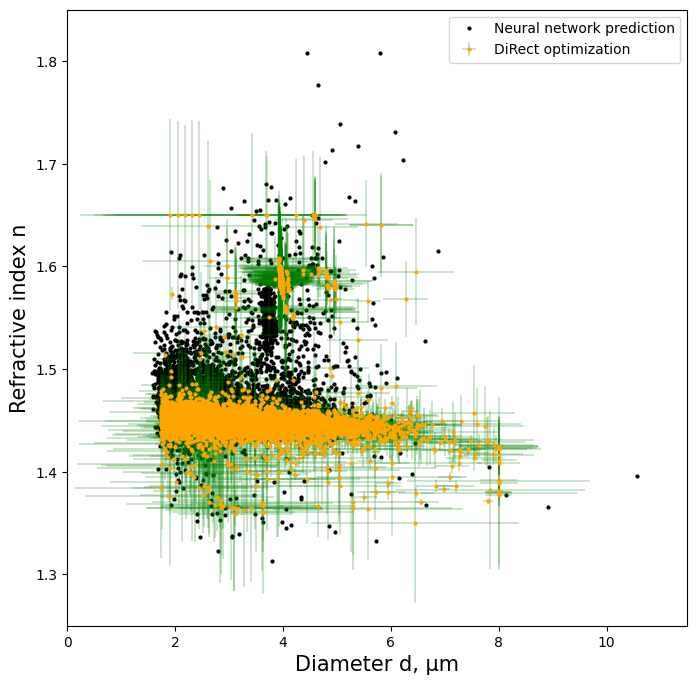

In [ ]:
# graphs(m_pred = ri_pred, x_pred = d_pred,  m_mie = ri_n, x_mie = d_n, xerr = d_sd, merr =ri_sd )
graphs(m_pred = ri_pred_new, x_pred = d_pred_new,  m_mie = ri_n_new, x_mie = d_n_new, xerr = d_sd_new, merr =ri_sd_new )

In [ ]:
len(ri_pred_new)

6020

In [ ]:
csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/milk/raw_milk_660nm.txt'
data = pd.read_csv(csv_file,  delimiter = '\t').to_numpy()
angles = np.array(data[:, 513:-2],  dtype=np.float32)
indicatrice = np.array(data[:,1:513],  dtype=np.float32)

In [ ]:
indicatrice_new = np.zeros((len(indicatrice),256))
for i in range(len(indicatrice)):
  indicatrice_new[i] = np.interp(torch.linspace(10, 65, 256), angles[i], indicatrice[i])
  indicatrice_new[i] = Mal_func(theta_array = torch.linspace(10, 65,256), data_arr = indicatrice_new[i], noise = False)



In [ ]:
indicatrice_new_2 = np.zeros((len(indicatrice),256))
for i in range(len(indicatrice)):
  indicatrice_new_2[i] = np.interp(torch.linspace(10, 65, 256), angles[i], indicatrice[i])

In [ ]:
!pip install PyMieScatt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyMieScatt: filename=PyMieScatt-1.8.1.1-py3-none-any.whl size=14972 sha256=ed479b5ebc95bc7e0d6fad4f2b5938ea6dc312ab439a301df378d0adaadf3b30
  Stored in directory: /root/.cache/pip/wheels/cc/bc/a8/be8dbdf0f044cd72ba870cc73acdb57d4f43d8f3a10e6cce78
Successfully built PyMieScatt


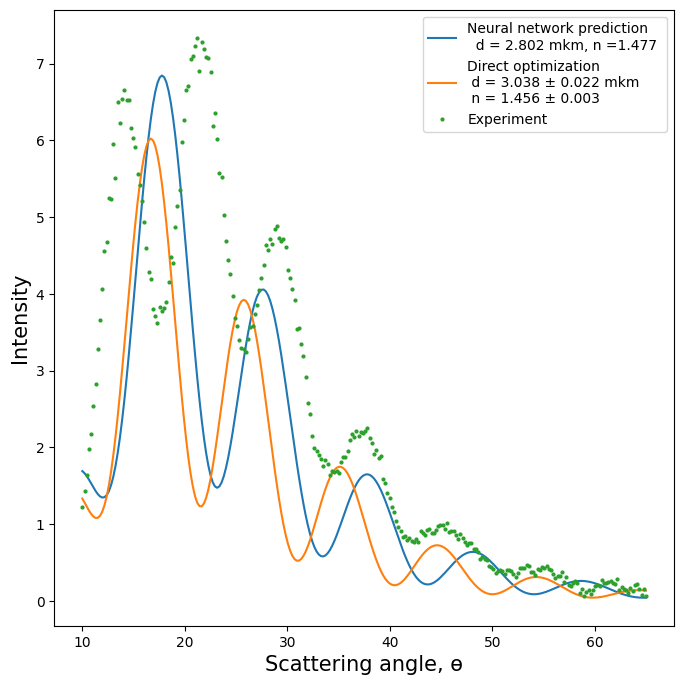

In [ ]:
import PyMieScatt as ps
index = 5#10 80 5 95
r_i = ri_pred[index]
d = d_pred[index]*1000
_,_,_, ind_nn = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.343,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_nn, noise = False)
plt.figure(figsize=(8,8))
plt.plot(np.linspace(10,65,256),indm,  label = f'Neural network prediction\n  d = {round(d/1000,3)} mkm, n ={round(r_i,3)} ')
#plt.title('Результат для латексных шаров', fontsize=13)
plt.legend()

r_i = ri_n[index]
d = d_n[index]*1000
_,_,_, ind_mie = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.343,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
indm = Mal_func(theta_array = np.linspace(10,65,256), data_arr = ind_mie, noise = False)
plt.plot(np.linspace(10,65,256),indm, label = f'Direct optimization\n d = {round(d/1000,3)} ± {round(d_sd[index],3)} mkm\n n = {round(ri_n[index],3)} ± {round(ri_sd[index],3)}')

#эксперимент

plt.plot(torch.linspace(10, 65, 256), indicatrice_new[index], marker = 'o', markersize = 2,linewidth = 0, label = 'Experiment')
# test_data[index]
plt.xlabel('Scattering angle, ɵ', fontsize=15)
plt.ylabel("Intensity", fontsize=15)
plt.legend()
plt.savefig('Результат для молока_1.svg')
